### Generating catalogs for phosim that merge Gaia, Skymapper and PanSTARRS data sets

To define a catalog to simulate the density of stars in the wavefront sensors we want to ensure (a) that our base catalog from Gaia does not undercount stars in dense regions and (b) that we have estimates of ugrizy colors for the Gaia stars. Here we compare the densities of stars from Gaia, PanSTARRS (PS1) and Skymapper. All catalogs are available through AXS which we use to cross match the catalogs

Nominally want to model source density to AB~21.5 (or fainter)

We note Gaia Completeness in the EDR3 (https://arxiv.org/pdf/2012.06242.pdf) compared to HST is 20% in Baade's window

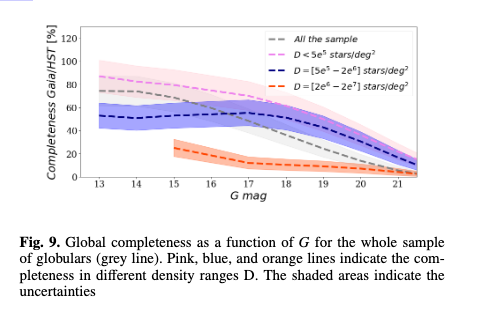

_NOTE_ to use this notebook will require access to epyc (at UW) and use of Spark

In [529]:
%matplotlib inline
import axs
import os

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import ascii

import pyspark.sql.functions as sparkfunc
from pyspark.sql.types import StructType, StructField

In [2]:
from pyspark.sql import SparkSession
spark_session = (SparkSession.builder
         .config('spark.master', "local[15]")
         .config('spark.driver.memory', '80G')
         .config("spark.sql.execution.arrow.enabled", "true")
         .config("spark.ui.proxyBase", "https://epyc.astro.washington.edu/jupyter/user/ctslater/proxy/4048")
         .enableHiveSupport()
         .getOrCreate())
spark_session

In [530]:
catalog = axs.AxsCatalog(spark_session)

In [531]:
#check the table exists
catalog.list_table_names()

['gaia_dr2_1am_dup',
 'allwise_1am_dup',
 'unwise_v1',
 'cklein_flare',
 'unwise_v2',
 'catalina_variables_n',
 'gaia',
 'gaia_dr2_1am_dup_ssd',
 'ztf_dr3_detections',
 'ps1',
 'gaia_dr2_wds_j2019',
 'gaia_dr2_wds_j2019_fall2020temp',
 'green19_stellar_params',
 'rosat_2rxs',
 'ztf_dr3',
 'rosat_2rxs_z4am_b2am',
 'ztf_dr3_2rxs_obj',
 'wtf_ztf_dr3',
 'ztf_wds_kjb_dr3',
 'ztf_aug2020_combined',
 'karenws_cut_wtf_fits_r_band',
 'karenws_cut_wtf_fits',
 'ztf_aug2020_combined_z4am_b2am',
 'ztf_aug2020_2rxs_obj',
 'skymapper_dr2',
 'test_skymapper',
 'skymapper_dr2_ver2',
 'skymapper_dr2_ver3',
 'ztf_rrlyr',
 'gaia_source_edr3',
 'gaia_edr3_distances',
 'rrlyrae_sample_andy',
 'stevengs_test_small_df',
 'ztf5',
 'ztf_wds_expected_kjb',
 'ztf_dr4_detections',
 'ztf_wds_kjb',
 'feh_rrlyr_ab_020620',
 'kepler_rrlyrae',
 'ztf_kepler_rrlyrae',
 'ztf_rrlyr_grid_50',
 'ps_uband']

In [6]:
# Load Skymapper, Gaia (EDR3) and PS1 data sets 
skymapper = catalog.load("skymapper_dr2_ver3")
ps = catalog.load("ps1")
gaia = catalog.load("gaia_source_edr3")

In [11]:
print("Skymapper counts {}".format(skymapper.count()))
print("PanSTARRS counts {}".format(ps.count()))
print("Gaia counts {}".format(gaia.count()))

Skymapper counts 589364177
PanSTARRS counts 2238951222
Gaia counts 2113651513


CPU times: user 54.9 ms, sys: 8.66 ms, total: 63.6 ms
Wall time: 43.6 ms


Text(0.5, 1.0, 'PanSTARRS')

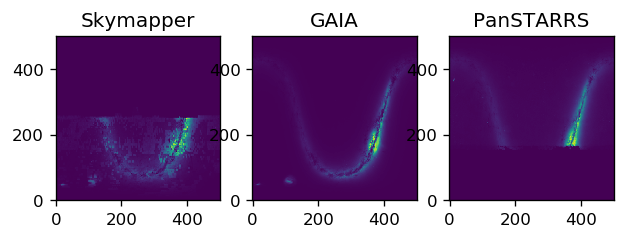

In [690]:
%%time
#plot sky distribution

matplotlib.rcParams['figure.dpi'] = 120
fig, axs = plt.subplots(1, 3)

results_s = histogram2d(skymapper, skymapper['ra'], skymapper['dec'], 500, 500, min1=0, max1=360, min2=-90, max2=90)
axs[0].imshow(results_s[2].T, origin='lower')
axs[0].set_title("Skymapper")

result_g = histogram2d(gaia, gaia['ra'], gaia['dec'], 500, 500, min1=0, max1=360, min2=-90, max2=90)
axs[1].imshow(result_g[2].T, origin='lower')
axs[1].set_title("GAIA")

result_p = histogram2d(ps, ps['ra'], ps['dec'], 500, 500, min1=0, max1=360, min2=-90, max2=90)
axs[2].imshow(result_p[2].T, origin='lower')
axs[2].set_title("PanSTARRS")

### Plot number magnitude distribution
Note that AXS matches to 1 arcsecond by default

In [577]:
%%time
# match over a test region
testra = 287.9869104
#testdec = -30.0748496
testdec = -60.0748496
d = 10.
skymapper_match = gaia.region(ra1=testra-d/np.cos(np.radians(testdec)), ra2=testra+d/np.cos(np.radians(testdec)), 
                            dec1=testdec-d, dec2=testdec+d).crossmatch(skymapper).select("object_id","u_psf","g_psf","r_psf","i_psf","z_psf",
                                                                      "ra","dec","source_id","bp_rp", "phot_g_mean_mag", 
                                                                      'phot_bp_mean_mag','phot_rp_mean_mag',"axsdist")

CPU times: user 12.8 ms, sys: 1.2 ms, total: 14 ms
Wall time: 322 ms


In [578]:
skypos = skymapper_match.select('ra', 'dec').toPandas()

/epyc/opt/anaconda/lib/python3.7/site-packages/pyarrow/__init__.py:152: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


In [579]:
from astropy.coordinates import SkyCoord
import astropy.units as u
eq = SkyCoord(skypos.ra, skypos.dec, unit=u.deg)

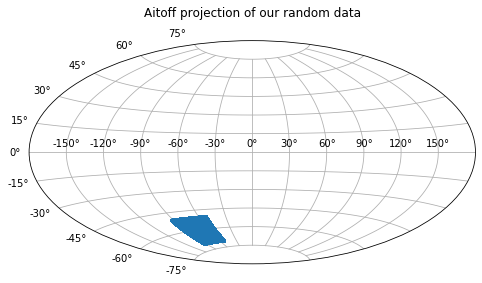

In [580]:
plt.figure(figsize=(8,4.2))
plt.subplot(111, projection="aitoff")
plt.title("Aitoff projection of our random data", y=1.08)
plt.grid(True)
plt.plot(eq.ra.wrap_at(180 * u.deg).radian, eq.dec.radian, 'o', markersize=2, alpha=0.3)
plt.subplots_adjust(top=0.95,bottom=0.0)
plt.show()

In [550]:
#match full data sets
skymapper_match_gaia = gaia.crossmatch(skymapper).select("ra","dec","source_id","bp_rp", "phot_g_mean_mag", 
                                                    'phot_bp_mean_mag','phot_rp_mean_mag',"axsdist",
                                                    "object_id","u_psf","g_psf","r_psf","i_psf","z_psf")

In [103]:
ps_match_gaia = gaia.crossmatch(ps).select("ra","dec","source_id","bp_rp", "phot_g_mean_mag", 
                                        'phot_bp_mean_mag','phot_rp_mean_mag',"axsdist",
                                        "gMeanPSFMag", "rMeanPSFMag",'iMeanPSFMag','zMeanPSFMag',"yMeanPSFMag")


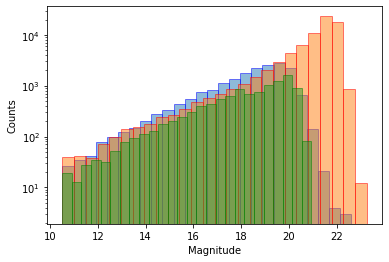

In [582]:
# compare densities of Gaia, PS, Skymapper
testra = 187.9869104
testdec = 0.0748496
d = 1.
nbins = 26

gaia_radec = gaia.region(ra1=testra-d/np.cos(np.radians(testdec)), ra2=testra+d/np.cos(np.radians(testdec)), dec1=testdec-d, dec2=testdec+d)
bins, counts = gaia_radec.select('phot_rp_mean_mag').filter(gaia_radec.phot_rp_mean_mag.between(10.5, 23.5)).rdd.flatMap(lambda x: x).histogram(nbins)
x=plt.hist(bins[:-1], bins=bins, weights=counts, alpha=0.5, ec='blue')
plt.yscale('log', nonposy='clip')
plt.xlabel("Magnitude")
plt.ylabel("Counts")

ps_radec = ps.region(ra1=testra-d/np.cos(np.radians(testdec)), ra2=testra+d/np.cos(np.radians(testdec)), dec1=testdec-d, dec2=testdec+d)
bins, counts = ps_radec.select('rMeanPSFMag').filter(ps_radec.rMeanPSFMag.between(10.5, 23.5)).rdd.flatMap(lambda x: x).histogram(nbins)
x=plt.hist(bins[:-1], bins=bins, weights=counts, alpha=0.5, ec='red')

skymapper_radec = skymapper.region(ra1=testra-d/np.cos(np.radians(testdec)), ra2=testra+d/np.cos(np.radians(testdec)), dec1=testdec-d, dec2=testdec+d)
bins, counts = skymapper_radec.select('r_psf').filter(skymapper_radec.r_psf.between(10.5, 23.5)).rdd.flatMap(lambda x: x).histogram(nbins)
x=plt.hist(bins[:-1], bins=bins, weights=counts, alpha=0.5, ec='green')


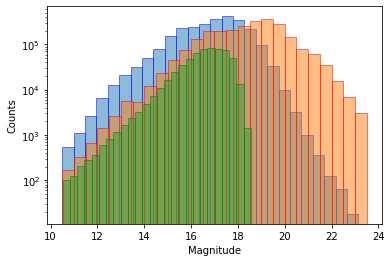

In [583]:
# compare densities of Gaia, PS, Skymapper Baades window
testra = 270.88380338652223
testdec = -30.035274475954893
d = 1.

gaia_radec = gaia.region(ra1=testra-d/np.cos(np.radians(testdec)), ra2=testra+d/np.cos(np.radians(testdec)), dec1=testdec-d, dec2=testdec+d)
bins, counts = gaia_radec.select('phot_rp_mean_mag').filter(gaia_radec.phot_rp_mean_mag.between(10.5, 23.5)).rdd.flatMap(lambda x: x).histogram(nbins)
x=plt.hist(bins[:-1], bins=bins, weights=counts, alpha=0.5, ec='blue')
plt.yscale('log', nonposy='clip')
plt.xlabel("Magnitude")
plt.ylabel("Counts")

ps_radec = ps.region(ra1=testra-d/np.cos(np.radians(testdec)), ra2=testra+d/np.cos(np.radians(testdec)), dec1=testdec-d, dec2=testdec+d)
bins, counts = ps_radec.select('rMeanPSFMag').filter(ps_radec.rMeanPSFMag.between(10.5, 23.5)).rdd.flatMap(lambda x: x).histogram(nbins)
x=plt.hist(bins[:-1], bins=bins, weights=counts, alpha=0.5, ec='red')

skymapper_radec = skymapper.region(ra1=testra-d/np.cos(np.radians(testdec)), ra2=testra+d/np.cos(np.radians(testdec)), dec1=testdec-d, dec2=testdec+d)
bins, counts = skymapper_radec.select('r_psf').filter(skymapper_radec.r_psf.between(10.5, 23.5)).rdd.flatMap(lambda x: x).histogram(nbins)
x=plt.hist(bins[:-1], bins=bins, weights=counts, alpha=0.5, ec='green')


In [584]:
#ratio of Skymapper to gaia density at r=21.5
magMax=21.5
data_set_s = skymapper.filter(skymapper.r_psf.between(5, magMax))
data_set_g = gaia.filter(gaia.phot_rp_mean_mag.between(5, magMax))
data_set_p = ps.filter(ps.rMeanPSFMag.between(5, magMax))

results_s = histogram2d(data_set_s, data_set_s['ra'], data_set_s['dec'], 500, 500, min1=0, max1=360, min2=-90, max2=90)
results_g = histogram2d(data_set_g, data_set_g['ra'], data_set_g['dec'], 500, 500, min1=0, max1=360, min2=-90, max2=90)
results_p = histogram2d(data_set_p, data_set_p['ra'], data_set_p['dec'], 500, 500, min1=0, max1=360, min2=-90, max2=90)

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


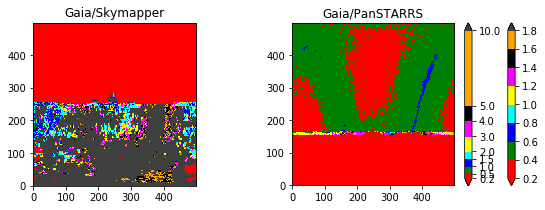

In [585]:
#plot ratios of PS/Gaia/Skymmapper source densities
import matplotlib as mpl
import matplotlib.colors as colors
def plot_ratio(dataset1, dataset2):
    ratio = dataset1[2].T / dataset2[2].T
    ratio[np.isinf(ratio)] = 0
    ratio[np.isnan(ratio)] = 0
    return ratio

fig, axs = plt.subplots( 1, 2, figsize=(10,3))
cmap_s = mpl.colors.ListedColormap(['red', 'green', 'blue', 'cyan', 'yellow','magenta', 'black', 'orange'])
cmap_s.set_over('0.25')
cmap_s.set_under('0.75')
bounds_s = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
norm_s = mpl.colors.BoundaryNorm(bounds_s, cmap_s.N)

cmap_p = mpl.colors.ListedColormap(['red', 'green', 'blue', 'cyan', 'yellow','magenta', 'black', 'orange'])
cmap_p.set_over('0.25')
cmap_p.set_under('0.75')
bounds_p = [0.2, 0.5, 1.0, 1.5, 2.0, 3., 4., 5., 10.]
norm_p = mpl.colors.BoundaryNorm(bounds_p, cmap_p.N)

ratio_gs = plot_ratio(results_g, results_s)
im_s = axs[0].imshow(ratio_gs, origin='lower', cmap=cmap_s, norm=norm_s, vmin=0, vmax=10., )
axs[0].set_title('Gaia/Skymapper')
fig.colorbar(im_s, cmap=cmap_s, norm=norm_s,
                                boundaries=[0] + bounds_s + [10],
                                extend='both',
                                ticks=bounds_s,
                                spacing='proportional',
                                orientation='vertical')

ratio_gp = plot_ratio(results_g, results_p)
im_p = axs[1].imshow(ratio_gp, origin='lower', cmap=cmap_p, norm=norm_p, vmin=0, vmax=10., )
axs[1].set_title('Gaia/PanSTARRS')

fig.colorbar(im_p, cmap=cmap_p, norm=norm_p,
                                boundaries=[0] + bounds_p + [20],
                                extend='both',
                                ticks=bounds_p,
                                spacing='proportional',
                                orientation='vertical')


To output the data for a phosim image we will use an AOV star (ie zero color in AB system) and then define the magnitude for phosim in the passband of choice (e.g. u,g,r,i,z). This means we will neeed ugrizy for all GAIA stars.

Skymapper: "u_psf","g_psf","r_psf","i_psf","z_psf"

PS1: "gMeanPSFMag", "rMeanPSFMag",'iMeanPSFMag','zMeanPSFMag',"yMeanPSFMag"

For any missing passband we should derive it from the other bands using a linear relation

Assuming we use PS as the default data set we augment the 

In [596]:
ps_match_skymapper = skymapper.crossmatch(ps).select("ra","dec","axsdist","gMeanPSFMag", "rMeanPSFMag",'iMeanPSFMag','zMeanPSFMag',
                                                     "yMeanPSFMag","object_id","u_psf","g_psf","r_psf","i_psf","z_psf","iMeanKronMag")


In [597]:
ps_skymapper_pd = ps_match_skymapper.toPandas()

/epyc/opt/anaconda/lib/python3.7/site-packages/pyarrow/__init__.py:152: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


Text(0, 0.5, 'iMeanPSFMag-iMeanKronMag')

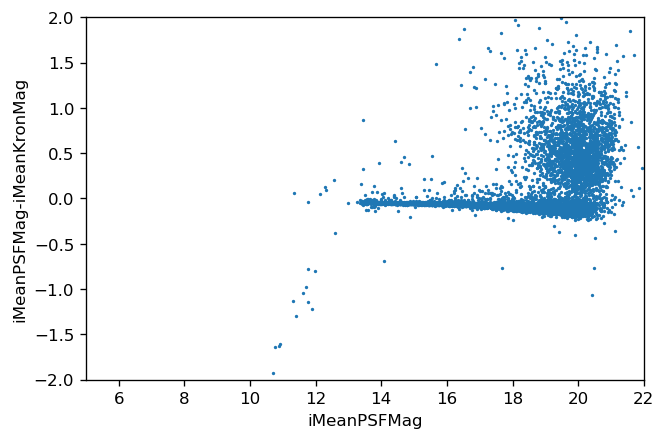

In [691]:
#create a star-galaxy separation query
fig, ax = plt.subplots()
ax.scatter(ps_skymapper_pd.iMeanPSFMag[0:10000],
           ps_skymapper_pd.iMeanPSFMag[0:10000]-ps_skymapper_pd.iMeanKronMag[0:10000],s=1)
ax.set_ylim(-2.,2.)
ax.set_xlim(5.,22.)
ax.set_xlabel("iMeanPSFMag")
ax.set_ylabel("iMeanPSFMag-iMeanKronMag")

Text(0, 0.5, 'u_psf')

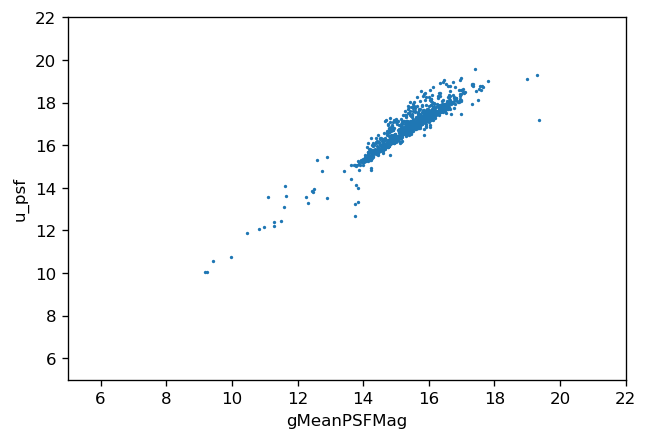

In [692]:
# ps vs skymapper to learn u band magnitude
#iPSFMag-iKronMag < 0.05 (stars)
fig, ax = plt.subplots()
condition = (ps_skymapper_pd.iMeanPSFMag-ps_skymapper_pd.iMeanKronMag)<0.05
ax.scatter(ps_skymapper_pd.gMeanPSFMag[condition][0:10000], ps_skymapper_pd.u_psf[condition][0:10000],s=1)
ax.set_xlim(5.,22.)
ax.set_ylim(5.,22.)
ax.set_xlabel("gMeanPSFMag")
ax.set_ylabel("u_psf")

Text(0, 0.5, 'u_psf_predicted')

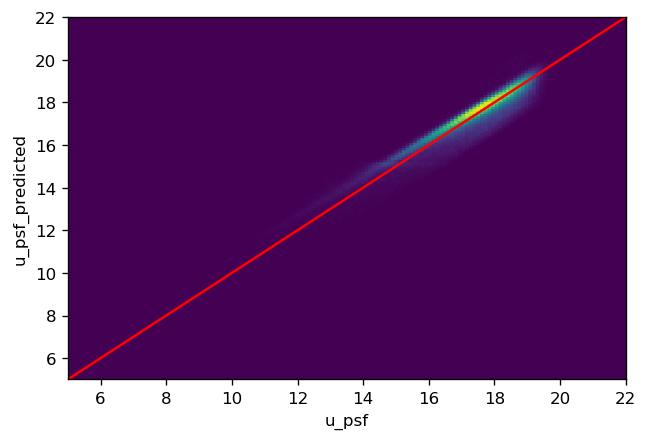

In [696]:
#model the u band from PS g r i z (fit to stars but apply to stars and galaxies)
# initially using g and r
from sklearn.linear_model import LinearRegression
ps_skymapper_pd['gr'] = ps_skymapper_pd['gMeanPSFMag'] - ps_skymapper_pd['rMeanPSFMag']
ps_skymapper_pd['ri'] = ps_skymapper_pd['rMeanPSFMag'] - ps_skymapper_pd['iMeanPSFMag']
ps_skymapper_pd['iz'] = ps_skymapper_pd['iMeanPSFMag'] - ps_skymapper_pd['zMeanPSFMag']

constraintTrain =((ps_skymapper_pd['gMeanPSFMag']>5) & (ps_skymapper_pd['u_psf']>5) & 
            (ps_skymapper_pd.iMeanPSFMag-ps_skymapper_pd.iMeanKronMag < 0.05))

constraintTest =((ps_skymapper_pd['gMeanPSFMag']>5) & (ps_skymapper_pd['u_psf']>5))

#X_train = ps_skymapper_pd[['gMeanPSFMag','gr','ri','iz']][constraintTrain].values
X_train = ps_skymapper_pd[['gMeanPSFMag','gr',]][constraintTrain].values
Y_train = ps_skymapper_pd['u_psf'][constraintTrain].values

#X_test = ps_skymapper_pd[['gMeanPSFMag','gr','ri','iz']][constraintTest].values
X_test = ps_skymapper_pd[['gMeanPSFMag','gr',]][constraintTest].values
Y_test = ps_skymapper_pd['u_psf'][constraintTest].values

lr = LinearRegression()
lr.fit(X_train, Y_train)  
y_fit = lr.predict(X_test)
fig, ax = plt.subplots()
ax.hexbin(Y_test, y_fit, gridsize=(150,150) ,extent=[5,22,5,22])
plt.plot([5.,22.],[5.,22.],color='red')
ax.set_xlabel("u_psf")
ax.set_ylabel("u_psf_predicted")

In [ ]:
# add "u band" synthetic data to PS and save as augmented catalog.
from pyspark.sql.functions import when
ps = ps.withColumn("uMeanPSFMag",
                               when((ps["rMeanPSFMag"] < -900) | (ps["gMeanPSFMag"] < -900), -999).otherwise(
                               lr.intercept_ + lr.coef_[0]*ps["gMeanPSFMag"] + lr.coef_[1]*(ps["gMeanPSFMag"] - ps["rMeanPSFMag"])
                               + lr.coef_[2]*(ps["rMeanPSFMag"] - ps["iMeanPSFMag"])
                               + lr.coef_[3]*(ps["iMeanPSFMag"] - ps["zMeanPSFMag"])))

In [697]:
ps = ps.withColumn("uMeanPSFMag",
                               when((ps["rMeanPSFMag"] < -900) | (ps["gMeanPSFMag"] < -900), -999).otherwise(
                               lr.intercept_ + lr.coef_[0]*ps["gMeanPSFMag"] + lr.coef_[1]*(ps["gMeanPSFMag"] - ps["rMeanPSFMag"])
                               ))

/epyc/opt/anaconda/lib/python3.7/site-packages/pyarrow/__init__.py:152: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


Text(0, 0.5, 'uMeanPSFMag')

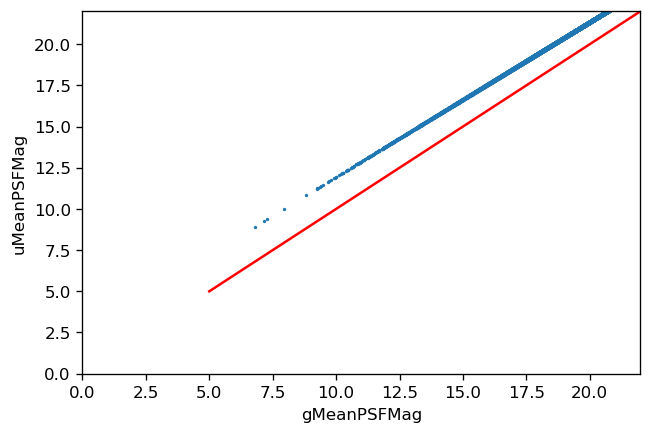

In [698]:
fig, ax = plt.subplots()
ax.scatter(ps.select("gMeanPSFMag").limit(100000).toPandas(),
           ps.select("uMeanPSFMag").limit(100000).toPandas(),s=1)
ax.plot([5.,22.],[5.,22.],color='red')
ax.set_xlim(0,22)
ax.set_ylim(0,22)
ax.set_xlabel("gMeanPSFMag")
ax.set_ylabel("uMeanPSFMag")

In [699]:
import os
passbands = {"u":"uMeanPSFMag", "g":"gMeanPSFMag", "r":"rMeanPSFMag", 
             "i":"iMeanPSFMag", "z":"zMeanPSFMag", "y":"yMeanPSFMag", }

def writePhosimCatalog(catalog, ra, dec, radius, phosimFile="stars.cat", passband='r', outDir="./", filterMag=True):
    '''Filter a source catalog and generate a phosim instance catalog'''

    #filter catalog
    phosimCat = catalog.region(ra1=ra-radius, ra2=ra+radius, dec1=dec-radius, 
                              dec2=dec+radius)
    #select columns and convert to pandas to output a single file
    outFile = os.path.join(outDir, phosimFile)    
    if (filterMag):
        phosimCat.select("objID","ra","dec",passbands[passband]).filter("{} > -900".format(passbands[passband])).toPandas().to_csv(outFile,index=False, sep='\t',
                                                                     header=["# Id","Ra","Decl","Mag"])
    else:
        phosimCat.select("objID","ra","dec",passbands[passband]).toPandas().to_csv(outFile,index=False, sep='\t',
                                                                     header=["# Id","Ra","Decl","Mag"])
    

In [700]:
ra = 287.9869104
dec = -30.0748496
radius = 2.
path = '/astro/users/ajc26/epycuser/LSST-Commissioning/aoc/phosim_cats'
writePhosimCatalog(ps, ra, dec, radius, phosimFile="stars.cat", passband='r', outDir=path, filterMag=True)

/epyc/opt/anaconda/lib/python3.7/site-packages/pyarrow/__init__.py:152: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


In [703]:
%%time
#save ps as a new axs file
catalog.save_axs_table(ps, "ps_uband_ver2")

CPU times: user 925 ms, sys: 321 ms, total: 1.25 s
Wall time: 1h 35min 10s


In [495]:
# read and output a catalog
psPhosim = catalog.load("ps_uband_ver2")

In [527]:
ra = 287.9869104
dec = -30.0748496
radius = 2.
path = '/astro/users/ajc26/epycuser/LSST-Commissioning/aoc/phosim_cats'
writePhosimCatalog(psPhosim, ra, dec, radius, phosimFile="stars.cat", passband='r', outDir=path)